<a href="https://colab.research.google.com/github/bhargavdeekshith14/de_project/blob/main/02_ANN_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminaries

We download the data:

In [19]:
!wget https://gitlab.com/andras.simonyi/10_days_AI_training_data/raw/65de5908dccf120762b305238e02610a8c18a3f9/titanic_train.csv

--2024-12-16 21:01:01--  https://gitlab.com/andras.simonyi/10_days_AI_training_data/raw/65de5908dccf120762b305238e02610a8c18a3f9/titanic_train.csv
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61194 (60K) [text/plain]
Saving to: ‘titanic_train.csv.1’

titanic_train.csv.1 100%[===================>]  59.76K  --.-KB/s    in 0.02s   

2024-12-16 21:01:02 (3.60 MB/s) - ‘titanic_train.csv.1’ saved [61194/61194]



# Trying it out -- on the Titanic data set

Short description of the data set:

> The titanic [...] data frames describe the survival status of individual passengers on the Titanic.

> Non-obvious variables:

>- Pclass -- Passenger Class  (1 = 1st; 2 = 2nd; 3 = 3rd)
>- Survived -- Survival  (0 = No; 1 = Yes)
>- SibSp -- Number of Siblings/Spouses Aboard
>- Parch -- Number of Parents/Children Aboard
>- Fare (ticket price in British pound)
>- Embarked -- Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)


In [20]:
import pandas as pd

df = pd.read_csv("titanic_train.csv")

For the sake of simplicity, we divide our data only into a training and a validation part:

In [21]:
print("shape:", df.shape)

shape: (891, 12)


## Inspecting and cleaning the data

In [22]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [23]:
df.describe(include="all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [24]:
df.isna().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


Based on our inspection, we drop the Cabin, Ticket, PassengerId, Name and index columns, since they are unusable for the prediction task:

In [25]:
columns_to_drop = ["Cabin", "Ticket", "PassengerId", "Name"]
df = df.drop(columns=columns_to_drop)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


We encode the the gender of passenger by numbers, and, as a primitive form of data imputation, replace missing age values with the mean age in the training data:

In [26]:
import numpy as np
age_mean = df.Age.mean()
replacements = {"Sex": {"male": 1, "female":0}, "Age": {np.NaN: age_mean}}
df.replace(replacements, inplace=True)
df.head()

<ipython-input-26-fb80f9842efc>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(replacements, inplace=True)


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,S
1,1,1,0,38.0,1,0,71.2833,C
2,1,3,0,26.0,0,0,7.9250,S
3,1,1,0,35.0,1,0,53.1000,S
4,0,3,1,35.0,0,0,8.0500,S


We drop the remaining rows with missing data:

In [27]:
print("Length before dropping:", len(df))
df.dropna(inplace=True)
df.reset_index()
print("Length after dropping:", len(df))

Length before dropping: 891
Length after dropping: 889


Finally, we one-hot encode the Embarked column.

In [28]:
df = pd.get_dummies(df)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,0,3,1,22.0,1,0,7.2500,False,False,True
1,1,1,0,38.0,1,0,71.2833,True,False,False
2,1,3,0,26.0,0,0,7.9250,False,False,True
3,1,1,0,35.0,1,0,53.1000,False,False,True
4,0,3,1,35.0,0,0,8.0500,False,False,True


For the sake of simplicity, we divide our data only into a training and a validation part:

In [42]:
# Check the data types
print(df.dtypes)

# Check for non-numeric columns
non_numeric_columns = df.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_columns)

# Convert categorical variables to numeric (if applicable)
if len(non_numeric_columns) > 0:
    df = pd.get_dummies(df, columns=non_numeric_columns, drop_first=True)

# Check for missing values
print("Missing values:", df.isnull().sum())

# Fill or drop missing values
df = df.fillna(0)  # Or use an appropriate imputation method

# Ensure all columns are of type float64
df = df.astype(float)


Survived        int64
Pclass          int64
Sex             int64
Age           float64
SibSp           int64
Parch           int64
Fare          float64
Embarked_C       bool
Embarked_Q       bool
Embarked_S       bool
dtype: object
Non-numeric columns: Index([], dtype='object')
Missing values: Survived      0
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64


In [43]:
from sklearn.model_selection import train_test_split

df_train, df_valid = train_test_split(df, test_size=0.1)

print("train shape:", df_train.shape)
print("validation shape:", df_valid.shape)

X_train = df_train.drop("Survived", axis=1).values
Y_train = df_train["Survived"].values

X_test = df_valid.drop("Survived", axis=1).values
Y_test = df_valid["Survived"].values

train shape: (800, 10)
validation shape: (89, 10)


# A simple neural network: Perceptron

![Perceptron](https://miro.medium.com/max/640/1*_Epn1FopggsgvwgyDA4o8w.png)

*Note*: it should be $x_{1}, x_{2}, x_{3}, x_{4}$ in the figure above.

We can visually understand the Perceptron by looking at the above image. For every training example, we first take the dot product of input features and weights, **w**. Then, we apply the Unit Step Function to make the prediction $\hat{y}$.

And if the prediction is wrong or in other words the model has misclassified that example, we make the update for the parameters **w** and **b** (bias):

<center>
$Δw = lr\cdot(y_{i}-\hat{y}_{i})$

$w \leftarrow w + Δw \cdot x_{i}$

$b \leftarrow b + Δw$
</center>

We don’t update when the prediction is correct (or the same as the true/target value y).

We create a Perceptron class, which implement single layer neural network with a `fit` and a `predict` method:
+ The `predict` method returns a vector of predictions for an array of samples, while
+ the `fit` method initializes the model parameters and trains the model using the perceptron learning rule.

In [44]:
class Perceptron:
    def __init__(self, learning_rate=0.001, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None

    def step_func(self, z):
        return np.where(z >= 0, 1, 0)

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for epoch in range(self.epochs):
            n_miss = 0
            for idx, x_i in enumerate(X):
                # Calculate the prediction
                linear_output = np.dot(x_i, self.weights) + self.bias
                y_hat = self.step_func(linear_output)

                # Update weights and bias if there is a misclassification
                if y[idx] != y_hat:
                    n_miss += 1
                    error = y[idx] - y_hat
                    self.weights += self.learning_rate * error * x_i
                    self.bias += self.learning_rate * error

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Misclassified: {n_miss}")

    def predict(self, X):
        linear_output = np.dot(X, self.weights) + self.bias
        return self.step_func(linear_output)

## Fitting a network

In [45]:
perceptron = Perceptron(learning_rate=0.01, epochs=1000)
perceptron.fit(X_train, Y_train)

Epoch 0, Misclassified: 329
Epoch 100, Misclassified: 248
Epoch 200, Misclassified: 233
Epoch 300, Misclassified: 225
Epoch 400, Misclassified: 239
Epoch 500, Misclassified: 225
Epoch 600, Misclassified: 228
Epoch 700, Misclassified: 223
Epoch 800, Misclassified: 227
Epoch 900, Misclassified: 218


Let's see the metrics on our validation data:

In [48]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
# Evaluate the model
Y_train_pred = perceptron.predict(X_train)
Y_test_pred = perceptron.predict(X_test)

print("Training Accuracy:", accuracy_score(Y_train, Y_train_pred))
print("Test Accuracy:", accuracy_score(Y_test, Y_test_pred))

# Classification report
print("Classification Report on Test Data:")
print(classification_report(Y_test, Y_test_pred, target_names=["Not Survived", "Survived"]))

Training Accuracy: 0.7575
Test Accuracy: 0.7078651685393258
Classification Report on Test Data:
              precision    recall  f1-score   support

Not Survived       0.83      0.68      0.75        57
    Survived       0.57      0.75      0.65        32

    accuracy                           0.71        89
   macro avg       0.70      0.72      0.70        89
weighted avg       0.74      0.71      0.71        89



In [ ]:
from sklearn.metrics import classification_report

Y_train_predicted = p.predict(X_train.to_numpy())
print(classification_report(Y_train, Y_train_predicted, labels=[1], target_names=["Survivor"]))

Y_test_predicted = p.predict(X_test.to_numpy())
print(classification_report(Y_test, Y_test_predicted, labels=[1], target_names=["Survivor"]))

              precision    recall  f1-score   support

    Survivor       0.83      0.37      0.51       309

   micro avg       0.83      0.37      0.51       309
   macro avg       0.83      0.37      0.51       309
weighted avg       0.83      0.37      0.51       309

              precision    recall  f1-score   support

    Survivor       0.81      0.42      0.55        31

   micro avg       0.81      0.42      0.55        31
   macro avg       0.81      0.42      0.55        31
weighted avg       0.81      0.42      0.55        31



In [51]:
Y_test

array([0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1.,
       0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
       1., 0., 0., 0.])

In [53]:
Y_test_pred[0:15].T

array([1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1])

# Build the Network again using Keras

In [56]:
from keras.models import Sequential
from keras.layers import Dense, Input

# Create the Sequential model
model = Sequential()

# Input layer
model.add(Input(shape=(9,)))  # Assuming 9 input features

# Add hidden layers (optional, you can tune this)
model.add(Dense(units=16, activation='relu'))  # First hidden layer with 16 neurons
model.add(Dense(units=8, activation='relu'))   # Second hidden layer with 8 neurons

# Add output layer
model.add(Dense(units=1, activation='sigmoid'))  # 1 output for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16)                  │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 305 (1.19 KB)

 Trainable params: 305 (1.19 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
epochs = 50
train = model.fit(X_train, Y_train, batch_size = 16, epochs = epochs,
    validation_data=(X_test, Y_test))

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6480 - loss: 1.1066 - val_accuracy: 0.7303 - val_loss: 0.6619
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6853 - loss: 0.6457 - val_accuracy: 0.7303 - val_loss: 0.5922
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6987 - loss: 0.5923 - val_accuracy: 0.7191 - val_loss: 0.5894
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6630 - loss: 0.6155 - val_accuracy: 0.7303 - val_loss: 0.5937
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6969 - loss: 0.5965 - val_accuracy: 0.7416 - val_loss: 0.5852
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7079 - loss: 0.6049 - val_accuracy: 0.7528 - val_loss: 0.5864
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6774 - loss: 0.6088 - val_accuracy: 0.7528 - val_loss: 0.5869
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6771 - loss: 0.6092 - val_accuracy: 0.7640 - val_loss:

Plot loss and accuracy

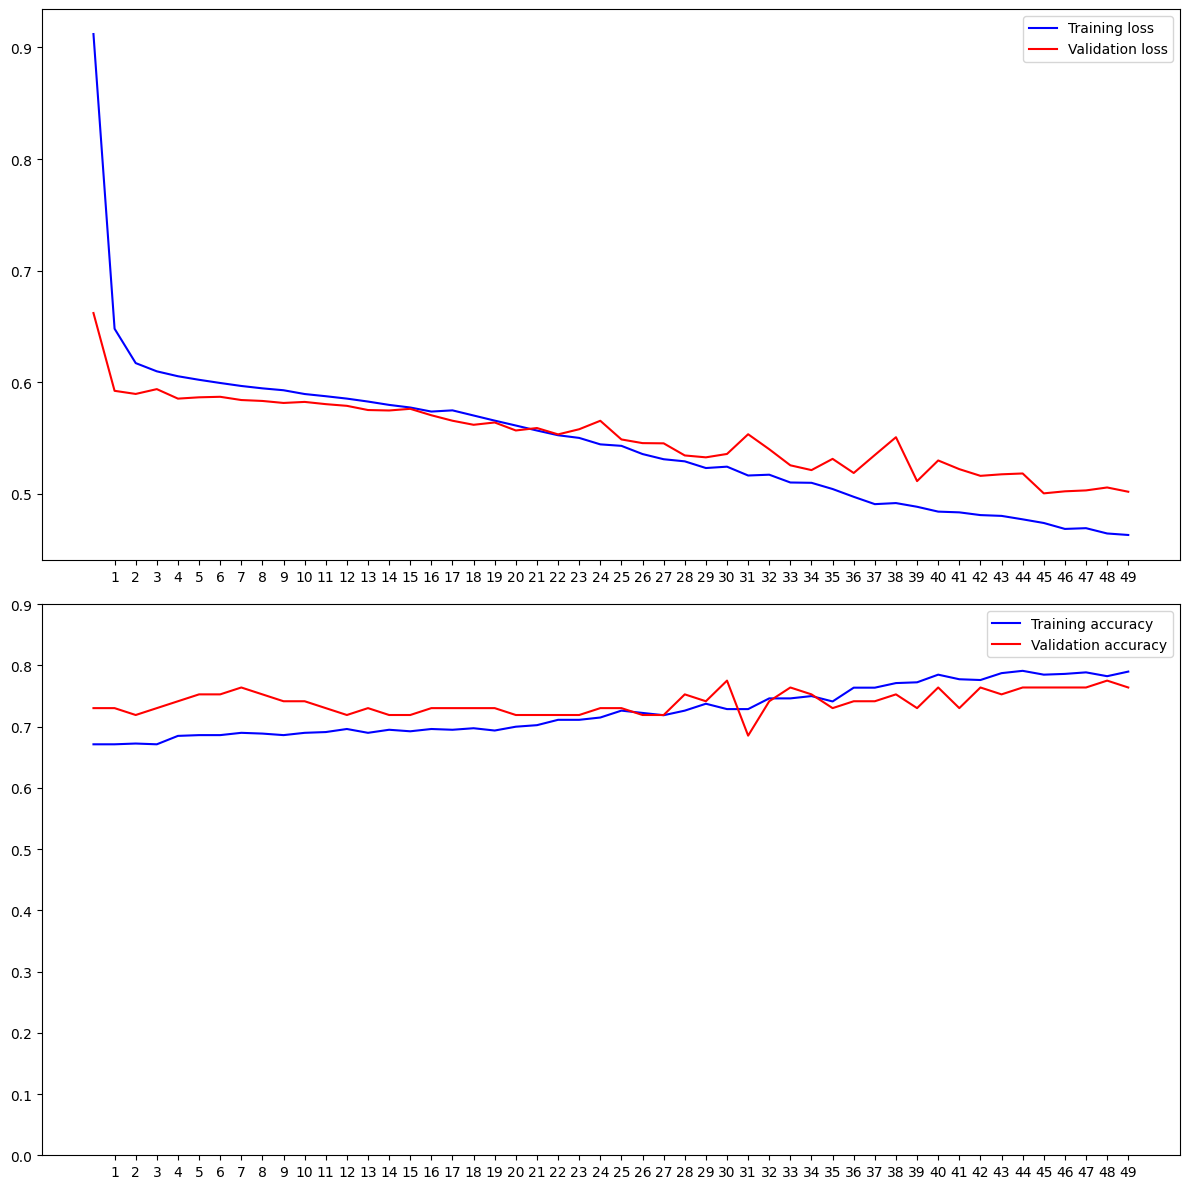

In [58]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(train.history['loss'], color='b', label="Training loss")
ax1.plot(train.history['val_loss'], color='r', label="Validation loss")
ax1.legend()
ax1.set_xticks(np.arange(1, epochs, 1))

ax2.plot(train.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(train.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.legend()
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.set_yticks(np.arange(0, 1, 0.1))

plt.tight_layout()
plt.show()

Test the model against validation data

In [59]:
(model.predict(X_test) > 0.5).astype("int32")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


array([[1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
    

In [60]:
from sklearn.metrics import classification_report

Y_train_predicted = (model.predict(X_train) > 0.5).astype("int32")
print(classification_report(Y_train, Y_train_predicted, labels=[1], target_names=["Survivor"]))

Y_test_predicted = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(Y_test, Y_test_predicted, labels=[1], target_names=["Survivor"]))

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
              precision    recall  f1-score   support

    Survivor       0.75      0.73      0.74       308

   micro avg       0.75      0.73      0.74       308
   macro avg       0.75      0.73      0.74       308
weighted avg       0.75      0.73      0.74       308

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
              precision    recall  f1-score   support

    Survivor       0.68      0.66      0.67        32

   micro avg       0.68      0.66      0.67        32
   macro avg       0.68      0.66      0.67        32
weighted avg       0.68      0.66      0.67        32



In [62]:
Y_test

array([0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1.,
       0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0.,
       1., 0., 0., 0.])

In [65]:
model.predict(X_test > 0.5).astype(int)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    